In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista
import ufl
import time
from mpi4py import MPI
from petsc4py import PETSc
import dolfinx
from dolfinx import fem, mesh, plot, nls, log, io
from dolfinx import cpp as _cpp
import meshio
import os
import sys

sys.path.append('../')
%load_ext autoreload
%autoreload 2

print(dolfinx.__version__)

0.7.2


In [3]:
from src.utils import *
from src.model import *

In [4]:
# 3D geometry


with io.XDMFFile(MPI.COMM_WORLD, '../raw-data/mesh225_normal/rve_225_normal.xdmf', 'r') as xdmf:
    domain = xdmf.read_mesh(name='Grid')
    # cells_local = np.arange(domain.topology.index_map(domain.topology.dim).size_local, dtype=np.int32)
    # midpoints = dolfinx.mesh.compute_midpoints(domain, domain.topology.dim, cells_local).T
    # should_refine = np.flatnonzero(all(midpoints)).astype(np.int32)
    # domain.topology.create_entities(1)
    # local_edges = dolfinx.mesh.compute_incident_entities(domain, should_refine, domain.topology.dim, 1)
    # domain = dolfinx.mesh.refine(domain, local_edges)

    # edges = mesh.locate_entities(domain, domain.topology.dim - 1, all)
    # domain.topology
    # domain = mesh.refine(domain, edges)
    # V = fem.VectorFunctionSpace(domain, ('Lagrange', 2))

In [5]:
topology, cells, geometry = plot.vtk_mesh(domain, domain.topology.dim)

In [5]:
geometry.shape

(30094, 3)

In [6]:
cells.shape

(115022,)

In [7]:
topology.shape

(575110,)

In [8]:
plot_mesh(domain)

Widget(value="<iframe src='http://localhost:37633/index.html?ui=P_0x7f4b70029a50_0&reconnect=auto' style='widt…

ERROR:root:Exception raised
ERROR:root:AttributeError("'NoneType' object has no attribute 'interactor'")
ERROR:root:Traceback (most recent call last):
  File "/home/bnherrerac/.local/lib/python3.10/site-packages/wslink/protocol.py", line 321, in onMessage
    results = func(*args, **kwargs)
  File "/home/bnherrerac/.local/lib/python3.10/site-packages/trame_server/protocol.py", line 199, in update_state
    with self.server.state:
  File "/home/bnherrerac/.local/lib/python3.10/site-packages/trame_server/state.py", line 226, in __exit__
    self.flush()
  File "/home/bnherrerac/.local/lib/python3.10/site-packages/trame_server/state.py", line 199, in flush
    coroutine = callback(**self._pushed_state)
  File "/home/bnherrerac/.local/lib/python3.10/site-packages/pyvista/trame/ui.py", line 220, in on_axis_visiblity_change
    renderer.show_axes()
  File "/home/bnherrerac/.local/lib/python3.10/site-packages/pyvista/plotting/renderer.py", line 1171, in show_axes
    self.add_axes()
  File "/

: 

In [6]:
results_folder = r"../../results-data/"
exp_folder = "rve_225"

In [7]:
model = PerfusionGasExchangeModel(mesh_path=None,
                                  results_path=results_folder,
                                  exp_path=exp_folder,
                                  params=None)

In [8]:
# max_dims = [76.07255, 74.9075,  74.99651]
# min_dims = [-1.12887,  0.07919,  0.09616]

# rve_225
max_dims = [226.4988, 225.138, 225.2962]
min_dims = [-1.4086, 0.08677, 0.0389]

# rve_225_normal
# max_dims = [226.4988, 225.1387, 225.2962]
# min_dims = [-1.4082, 0.0866, 0.03899]

# mesh225_dilated
# max_dims = [226.3880, 224.8622, 225.0170]
# min_dims = [-1.14634, -0.0851, 0.2545]

# mesh225_eroded
# max_dims = [226.01744, 224.76256, 224.7918]
# min_dims = [-1.2616, 0.4544, 0.2872]

model.Setup(domain, atol = 1E-3, max_dims = max_dims, min_dims = min_dims, imported=True, infinite=False)
model.parameter_setup()
model.p_params["uin"] = 800/3

max_dims = [226.4988, 225.138, 225.2962]
min_dims = [-1.4086, 0.08677, 0.0389]
Total number = 42710
Inlet number = 633
Outlet number = 668
Air number = 41409


In [8]:
p, u = model.Perfusion(domain, plot=True, save=True)

In [ ]:
model.results_path

'../../results-data/rve_test'

In [ ]:
p_val = 0
guess = model.GasExchange(domain, guess=None, save=False, 
                          plot=False, p_val = p_val, 
                          postprocess=False, plot_lines=False)
N = 10
for i in range(N):
    p_val += 1/N
    if i != N-1:
        guess = model.GasExchange(domain, guess=guess, save=False, 
                                  plot=False, p_val = p_val, 
                                  postprocess=False, plot_lines=False)
    else:
        guess = model.GasExchange(domain, guess=guess, save=True, 
                                  plot=False, p_val = p_val, 
                                  postprocess=True, plot_lines=False)

In [9]:
area = calculate_area(domain, model.ds, 1)
print(area)

6964.902262204516


In [15]:
def inlet(x):
    return np.isclose(x[0], model.min_dims[0], atol=0.5)
def outlet(x):
    return np.isclose(x[0], model.max_dims[0], atol=0.5)
def all(x):
    return np.full(x.shape[1], True, dtype=bool)
def both(x):
    return np.logical_or(inlet(x), outlet(x))
def sides(x):
    return np.logical_or(np.isclose(x[2], model.min_dims[2], atol=1), np.isclose(x[2], model.max_dims[2], atol=3))

In [16]:
inlet_facets = mesh.locate_entities_boundary(domain, model.fdim, inlet)
outlet_facets = mesh.locate_entities_boundary(domain, model.fdim, outlet)
all_facets = mesh.locate_entities_boundary(domain, model.fdim, all)
both_facets = mesh.locate_entities_boundary(domain, model.fdim, both)
air_facets = np.setdiff1d(all_facets, both_facets)
side_facets = mesh.locate_entities_boundary(domain, model.fdim, sides)

In [22]:
outlet_facets

array([  1035,   1127,   1304,   1638,   1639,   1777,   2020,   2027,
         2149,   2151,   2159,   2163,   2166,   2171,   2407,   3187,
         3774,   3777,   3779,   3782,   3789,   3790,   4171,   4172,
         4177,   4304,   4305,   4307,   4312,   4331,   4334,   4335,
         4428,   4435,   4439,   4465,   4585,   4695,   4774,   5130,
         5131,   5133,   5278,   5280,   5501,   5903,   6454,   6455,
         6456,   6459,   6461,   6466,   6498,   6514,   6721,   6727,
         7001,   7005,   7183,   7184,   7189,   7190,   8105,   9147,
         9149,   9153,   9175,   9181,   9182,   9196,   9207,   9211,
         9216,   9242,   9246,   9264,   9265,   9266,   9373,   9523,
         9527,   9536,   9540,   9547,   9585,   9603,   9612,   9876,
         9877,   9879,   9882,  10216,  10219,  10340,  10341,  10397,
        10404,  10405,  10413,  10465,  10466,  10468,  10473,  10475,
        10478,  10480,  10485,  10491,  10492,  10622,  10624,  10626,
      

In [17]:
pyvista.set_jupyter_backend('client')
pyvista.global_theme.background = 'white'
pyvista.global_theme.cmap = 'Blues'
pyvista.global_theme.line_width = 0.2
pyvista.global_theme.lighting_params.diffuse = 1
pyvista.global_theme.lighting_params.roughness = 1
pyvista.global_theme.lighting_params.metallic = 1
pyvista.global_theme.lighting_params.specular = 0

In [18]:
# Filter out ghosted cells
num_cells_local = mesh.locate_entities_boundary(domain, model.fdim, all)
print(f"num_cells_local = {num_cells_local}")
marker = np.zeros(np.max(num_cells_local)+1, dtype=np.int32) 
marker[inlet_facets] = 1 
marker[outlet_facets] = 2
# marker[air_facets] = 1

topology, cell_types, x = dolfinx.plot.vtk_mesh(domain, model.fdim, np.arange(np.max(num_cells_local)+1, dtype=np.int32))

p = pyvista.Plotter(window_size=[1700,1200], lighting='three lights')
# p.camera_position = [(549.2903053536529, 549.3577041036528, 450),
#  (112.54529812499999, 112.612696875, 112.667614875),
#  (0.0, 0.0, 1.0)]
grid = pyvista.UnstructuredGrid(topology, cell_types, x)
grid.cell_data["Marker"] = marker
grid.set_active_scalars("Marker")
p.add_mesh(grid, show_edges=True, edge_color="#000000")
p.remove_scalar_bar()
# if pyvista.OFF_SCREEN:
figure = p.screenshot("marked_mesh.png")
p.show()

ERROR:root:Attempt to use a texture buffer exceeding your hardware's limits. This can happen when trying to color by cell data with a large dataset. Hardware limit is 65536 values while 251399 was requested.
2024-02-09 22:08:37.722 ( 116.917s) [        13EF11C0]   vtkTextureObject.cxx:1025   ERR| vtkTextureObject (0x562ba1b16f30): Attempt to use a texture buffer exceeding your hardware's limits. This can happen when trying to color by cell data with a large dataset. Hardware limit is 65536 values while 251399 was requested.
2024-02-09 22:08:37.773 ( 116.968s) [        13EF11C0]   vtkTextureObject.cxx:1025   ERR| vtkTextureObject (0x562ba27e5c50): Attempt to use a texture buffer exceeding your hardware's limits. This can happen when trying to color by cell data with a large dataset. Hardware limit is 65536 values while 251399 was requested.
ERROR:root:Attempt to use a texture buffer exceeding your hardware's limits. This can happen when trying to color by cell data with a large dataset.

num_cells_local = [     0      1      4 ... 251393 251396 251398]


Widget(value="<iframe src='http://localhost:34033/index.html?ui=P_0x7f9dbf3a1de0_1&reconnect=auto' style='widt…

In [16]:
p.camera_position

[(549.2903053536529, 549.3577041036528, 549.4126221036529),
 (112.54529812499999, 112.612696875, 112.667614875),
 (0.0, 0.0, 1.0)]

[ -0.95   3.78   8.5   13.23  17.95  22.68  27.4   32.12  36.85  41.57
  46.3   55.74  65.19  74.64  84.09  93.54 102.99 112.44 121.88 131.33
 140.78 150.23 159.68 169.13 178.57 188.02 197.47 206.92 216.37 225.82
   1.42   6.14  10.86  15.59  20.31]


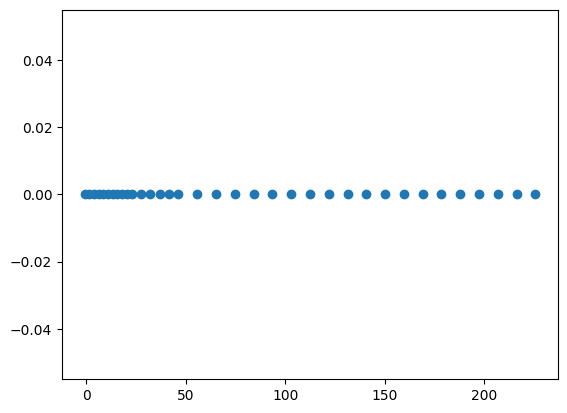

In [27]:
# Nodes for slicing

NN = 25
b = 226.017
a = -1.146
edge = 0.2

# Chebyshev
# xs = []
# for i in range(1,NN+1):
    # xs.append(0.5*(a+b)+0.5*(b-a)*np.cos( ((2*i-1) * np.pi) / (2*NN))) 
# xs = np.array(xs)

# Equispaced
xs = np.linspace(a+edge, b-edge, NN)

m = np.median(xs)

t = []
for i in range(5):
    t.append((xs[i]+xs[i+1])/2)

xs = np.sort(np.round(np.array((xs.tolist() + t)), 2))

t = []
for i in range(5):
    t.append((xs[i]+xs[i+1])/2)

xs = np.round(np.array((xs.tolist() + t)), 2)

print(xs)

plt.scatter(xs, np.zeros_like(xs))
# plt.scatter(a, 0, color='red')
# plt.scatter(b, 0, color='red')
# 

In [28]:
with np.printoptions(precision=3, suppress=True):
    print(m)
    print(np.round(xs-m, 2))

112.43549999999999
[-113.39 -108.66 -103.94  -99.21  -94.49  -89.76  -85.04  -80.32  -75.59
  -70.87  -66.14  -56.7   -47.25  -37.8   -28.35  -18.9    -9.45    0.
    9.44   18.89   28.34   37.79   47.24   56.69   66.13   75.58   85.03
   94.48  103.93  113.38 -111.02 -106.3  -101.58  -96.85  -92.13]
